In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
from time import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, 
                                transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

This picture is a  8


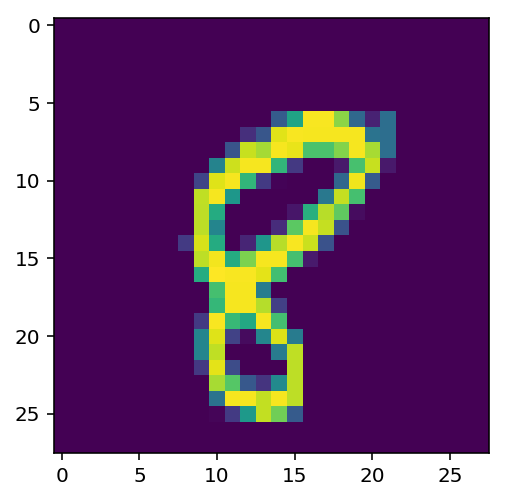

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(trainloader))
print("This picture is a ",labels[0].numpy())
plt.imshow(images[0].view(28,28));

## Building a model

In [4]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [6]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy

## Training the model

In [7]:
epochs = 3
print_every = 100
steps = 0
t0 = time()
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0
print('Tempo total para treino: ', round((time()-t0)/60,3), ' min')                  

Epoch: 1/3...  Loss: 2.2306
Epoch: 1/3...  Loss: 1.9519
Epoch: 1/3...  Loss: 1.4449
Epoch: 1/3...  Loss: 1.0041
Epoch: 1/3...  Loss: 0.7623
Epoch: 1/3...  Loss: 0.6481
Epoch: 1/3...  Loss: 0.5474
Epoch: 1/3...  Loss: 0.5156
Epoch: 1/3...  Loss: 0.4783
Epoch: 2/3...  Loss: 0.2636
Epoch: 2/3...  Loss: 0.4181
Epoch: 2/3...  Loss: 0.4218
Epoch: 2/3...  Loss: 0.4061
Epoch: 2/3...  Loss: 0.3899
Epoch: 2/3...  Loss: 0.3573
Epoch: 2/3...  Loss: 0.3638
Epoch: 2/3...  Loss: 0.3765
Epoch: 2/3...  Loss: 0.3441
Epoch: 3/3...  Loss: 0.0835
Epoch: 3/3...  Loss: 0.3491
Epoch: 3/3...  Loss: 0.3276
Epoch: 3/3...  Loss: 0.3119
Epoch: 3/3...  Loss: 0.3324
Epoch: 3/3...  Loss: 0.3193
Epoch: 3/3...  Loss: 0.3209
Epoch: 3/3...  Loss: 0.3110
Epoch: 3/3...  Loss: 0.3048
Epoch: 3/3...  Loss: 0.2951
Tempo total para treino:  0.821  min


## Predictions

/home/alberto/myapps/anaconda3-5/envs/pytorch/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


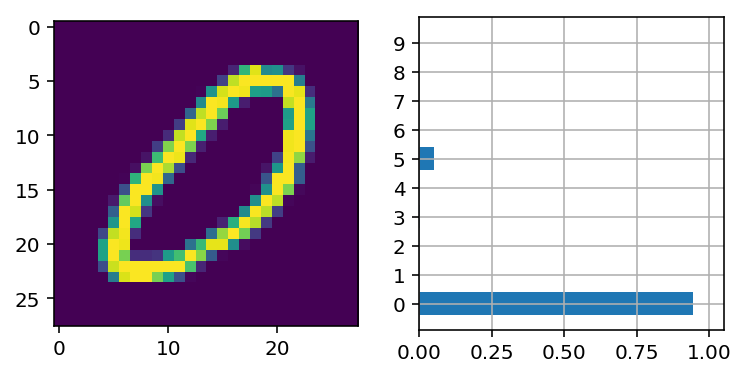

In [8]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(images[0].view(28,28));
#ax1.imshow(x_test[177], cmap = plt.cm.binary)
ax2.barh(np.arange(10), ps.resize(10).numpy())
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10));
ax2.set_xticks([0,0.25,0.5,0.75,1.0])
ax2.set_xlim(0, 1.05)
ax2.grid()

## Saving the trained model

In [9]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (logits): Linear(in_features=64, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'logits.weight', 'logits.bias'])


In [10]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [128, 64],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'MNIST_checkpoint.pth')

## Loading a trained model

In [11]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'][0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(checkpoint['hidden_layers'][0], checkpoint['hidden_layers'][1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(checkpoint['hidden_layers'][1], checkpoint['output_size']))]))
    #model = Network(checkpoint['input_size'],
    #                checkpoint['output_size'],
    #                checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [12]:
new_model = load_checkpoint('MNIST_checkpoint.pth')
print(new_model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (logits): Linear(in_features=64, out_features=10, bias=True)
)


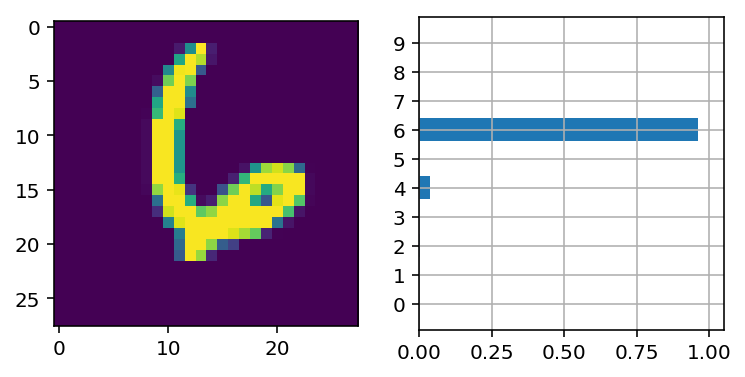

In [13]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = new_model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(images[0].view(28,28));
#ax1.imshow(x_test[177], cmap = plt.cm.binary)
ax2.barh(np.arange(10), ps.resize(10).numpy())
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10));
ax2.set_xticks([0,0.25,0.5,0.75,1.0])
ax2.set_xlim(0, 1.05)
ax2.grid()

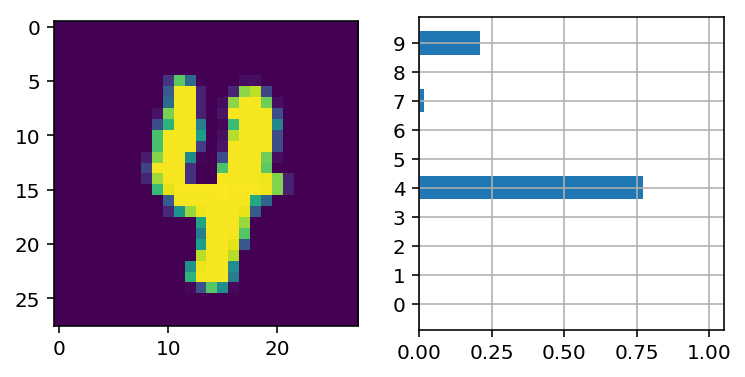

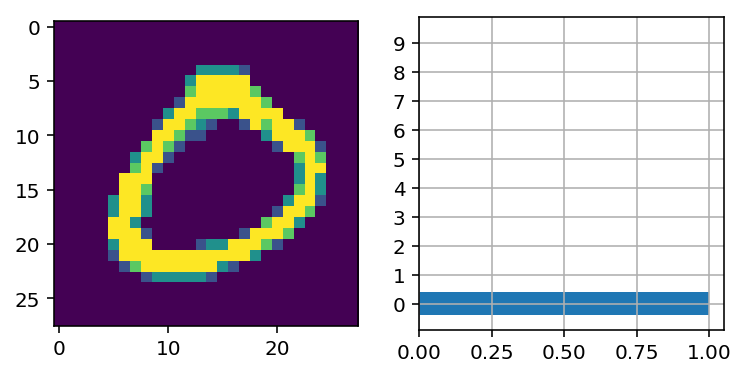

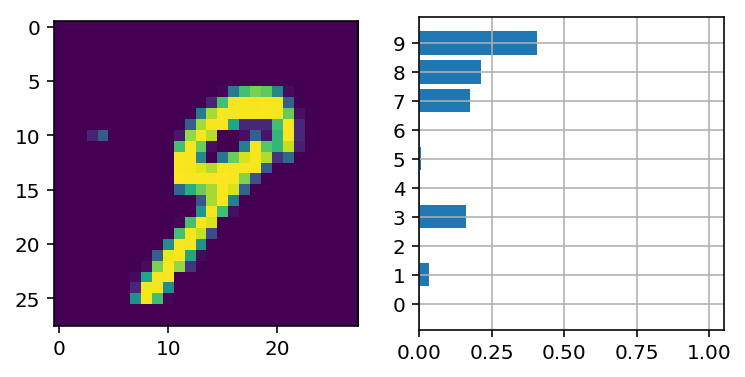

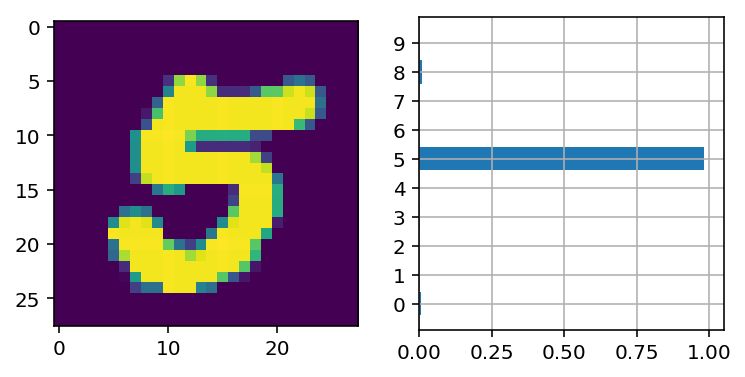

In [14]:
images, labels = next(iter(trainloader))

for i in range(0,4):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logits = new_model.forward(img)
    ps = F.softmax(logits, dim=1)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(images[i].view(28,28));
    ax2.barh(np.arange(10), ps.resize(10).numpy())
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10));
    ax2.set_xticks([0,0.25,0.5,0.75,1.0])
    ax2.set_xlim(0, 1.05)
    ax2.grid()
    